# Threshold-Based Segmentation (TBS) for Artifact Removal

Removing artifacts from an image using threshold-based segmentation involves the partition of the image $I$ into two (or more) regions, typically foreground and background, using a binary image, or mask $B$. Each pixel in the binary mask $B_{i,j}$ can have one of two values: 0 or 1. The value a pixel takes in the binary image depends upon the value of the corresponding pixel $I_{i,j}$ in image $I$ relative to a manually designated, or automatically selected, threshold $T$.  If $I_{i,j} > T$, then the value of the corresponding pixel in the binary mask $B_{i,j}$ is 1, otherwise,  $B_{i,j}$ is 0.
In other words,

```{math}
:label: global_threshold
M_{i,j} = \begin{cases}
1 & \text{if} I_{i,j} > T \\
0 & \text{if} I_{I,j} \le T \\
\end{cases}
```

Applying the binary mask $B$ to the image $I$ results in a new copy of image $I$, say, $I_t$ of the same shape and size as $I$, except all pixels in $I$ that are less than or equal to the threshold $T$ have a value of 0 in $I_t$. All other pixel values remain unchanged. Assuming the threshold $T$ is set appropriately, this places all objects of interest in the foreground (shown as white), and all other objects, artifacts, text, and anomalies in the background (shown as black).

So, setting an appropriate threshold is critically important. One that is too low tends to merge too many image structures and results in over-segmentation. A threshold that is too high may remove important structural data from the image.  The simplest approach is to set the threshold $T$ manually. To illustrate, let’s create a binary mask using threshold $T=30$.

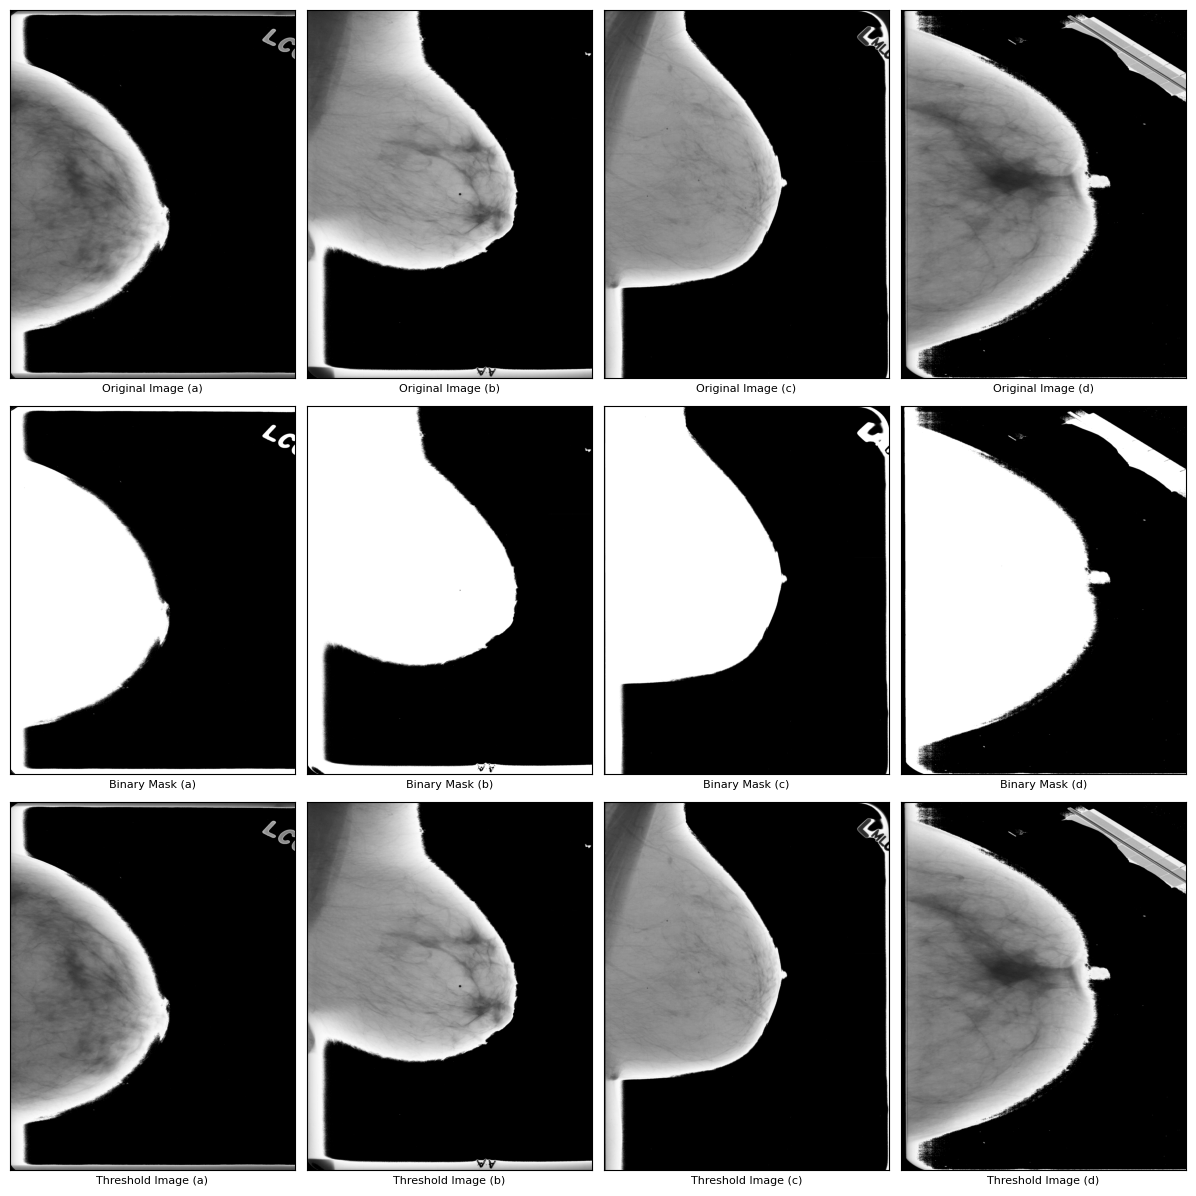

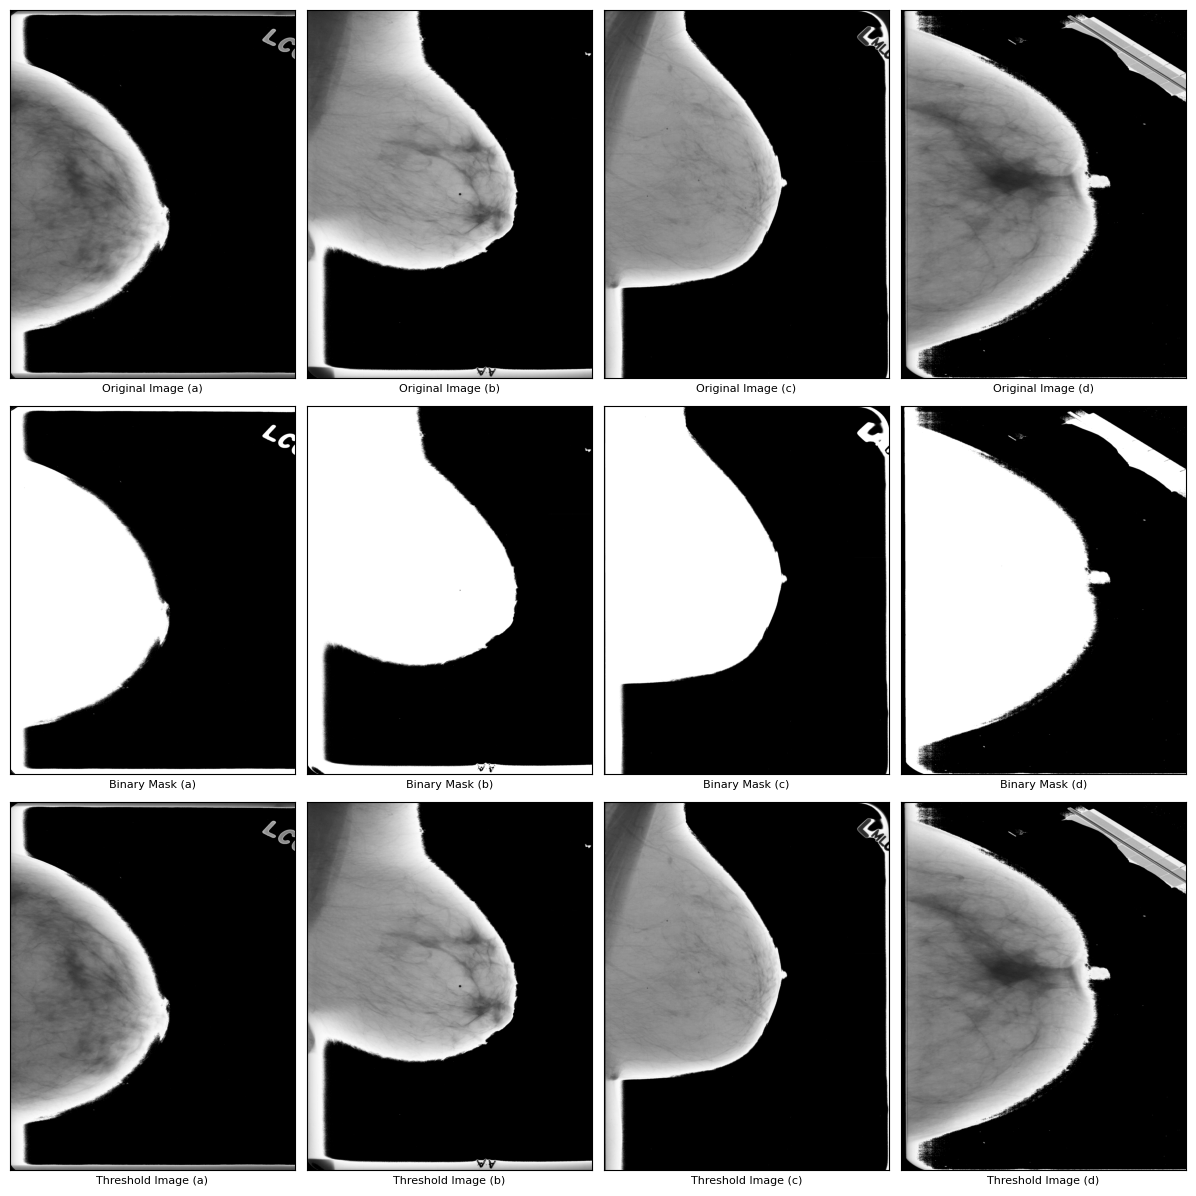

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import cv2
import numpy as np
import matplotlib.pyplot as plt
from myst_nb import glue
from bcd.utils.image import convert_uint8

img1 = "data/image/2_exp/train/benign/2a44122c-f831-4220-95a8-408bcafcf2ce.png"
img2 = "data/image/2_exp/train/benign/3f72309d-7cd9-4e30-ae81-073adb541bcd.png"
img3 = "data/image/2_exp/train/benign/97556037-b959-4395-830b-380dcac2d58e.png"
img4 = "data/image/2_exp/train/malignant/6cdf46d8-596b-47ab-a428-c8769733c93c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

img1 = convert_uint8(img1)
img2 = convert_uint8(img2)
img3 = convert_uint8(img3)
img4 = convert_uint8(img4)

r, bm1 = cv2.threshold(img1, 30, 255, cv2.THRESH_BINARY)
r, bm2 = cv2.threshold(img2, 30, 255, cv2.THRESH_BINARY)
r, bm3 = cv2.threshold(img3, 30, 255, cv2.THRESH_BINARY)
r, bm4 = cv2.threshold(img4, 30, 255, cv2.THRESH_BINARY)

img1t = np.bitwise_and(img1, bm1)
img2t = np.bitwise_and(img2, bm2)
img3t = np.bitwise_and(img3, bm3)
img4t = np.bitwise_and(img4, bm4)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')
_ = axes[2,0].imshow(img1t, cmap='gray', aspect='auto')
_ = axes[2,1].imshow(img2t, cmap='gray',aspect='auto')
_ = axes[2,2].imshow(img3t, cmap='gray',aspect='auto')
_ = axes[2,3].imshow(img4t, cmap='gray',aspect='auto')

imgtypes = ['Original Image', 'Binary Mask', 'Threshold Image']
labels = np.array(["(a)", "(b)", "(c)", "(d)"])
for i, imgtype in enumerate(imgtypes):
    for j, label in enumerate(labels):
        _ = axes[i,j].set_xlabel(f"{imgtype} {label}")
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("tbs1", fig)

```{glue:figure} tbs1
---
align: center
name: tbs1_fig
---
Binary Masking with Threshold $T=30$ with original image, binary mask and threshold image.
```

This simple binary mask {numref}`tbs1_fig` shows how artifacts can be separated from the image; however, we lose detail in the breast tissue, indicating that our threshold is likely set to a value which is too high for this application.

## Automated Thresholding

Setting an appropriate threshold is critically important. One that is too low tends to merge too many image structures, and a threshold that is too high may remove important structural data from the image. Manually selecting a threshold value is often suboptimal due to bias that may be introduced. In many cases, especially in biomedical imaging, we want the threshold $T$ to be set automatically such that the pixels in the region of interest correspond most optimally to the ‘1’ pixel, and those in the background correspond to the ‘0’ pixel values in the binary mask.

Literature is replete with automated binary threshold methods, most of which can be classified as either global thresholding or adaptive thresholding.

### Global Thresholding

Global thresholding works by applying a single threshold value $T$ to an image. Several of the most commonly used global thresholding methods are:

- Mean Thresholding
- ISOData Method
- Li Method
- Yen Method
- Triangle Method
- OTSU’s Method.

We’ll briefly introduce each of these methods and illustrate their performance on our test images above using the scikit-image {cite}`ThresholdingSkimage22` package.

#### Mean Thresholding

A simple, albiet naive approach is to set $T$ to the mean of the pixel values.  Let's illustrate the mean threshold applied to our test images.

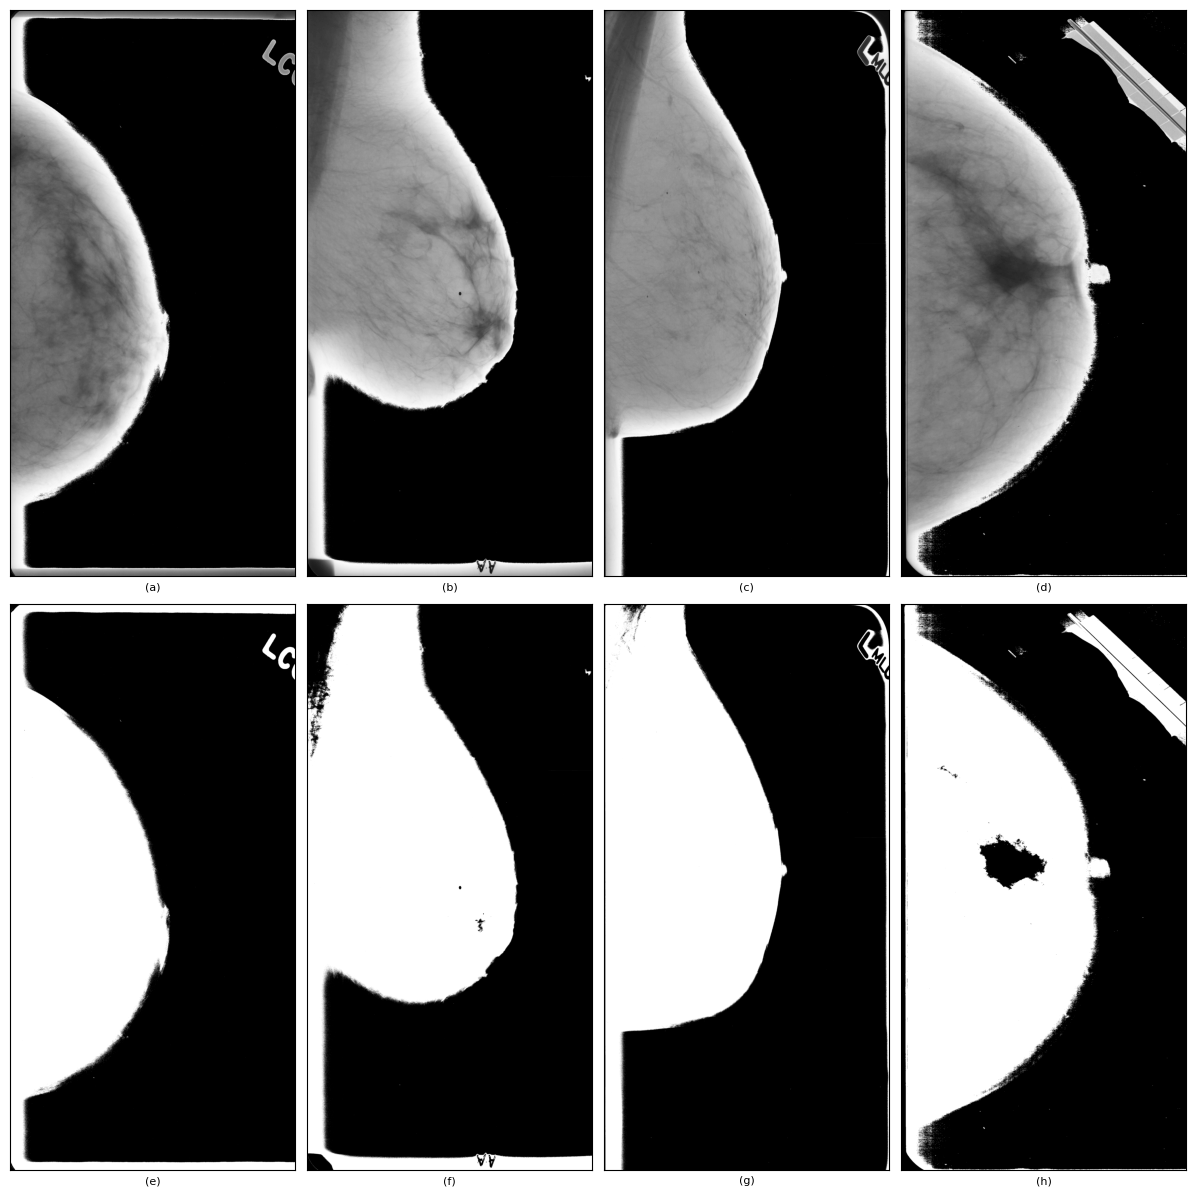

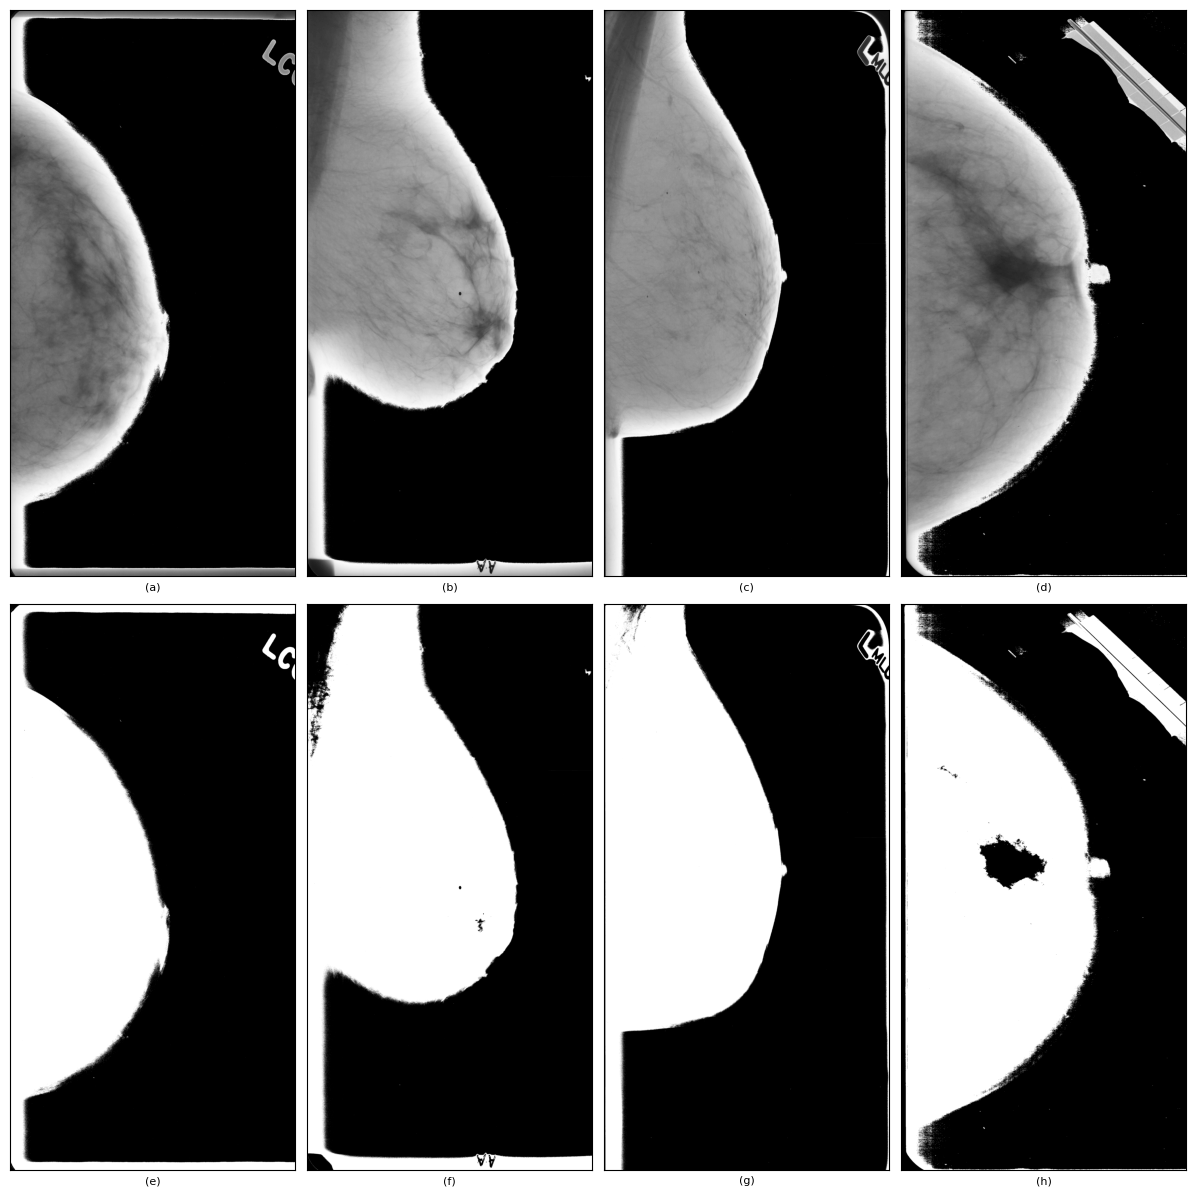

In [2]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_mean
from myst_nb import glue

t1 = threshold_mean(img1)
t2 = threshold_mean(img2)
t3 = threshold_mean(img3)
t4 = threshold_mean(img4)

bm1 = img1 > t1
bm2 = img2 > t2
bm3 = img3 > t3
bm4 = img4 > t4

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("bm2", fig)

```{glue:figure} bm2
---
align: center
name: bm2_fig
---
Binary Masking with Mean Threshold
```

#### ISOData Method
The ISOData threshold {cite}`PictureThresholdingUsing1978` is an iterative method for selecting $T$. An initial threshold $T$ is set, then the average pixel values above and below this initial threshold are computed. The new threshold is set to the average of the two values, and this process iterates until the threshold is larger than the average brightness between the two regions.

Let's examine the performance of the ISOData method on our test images.

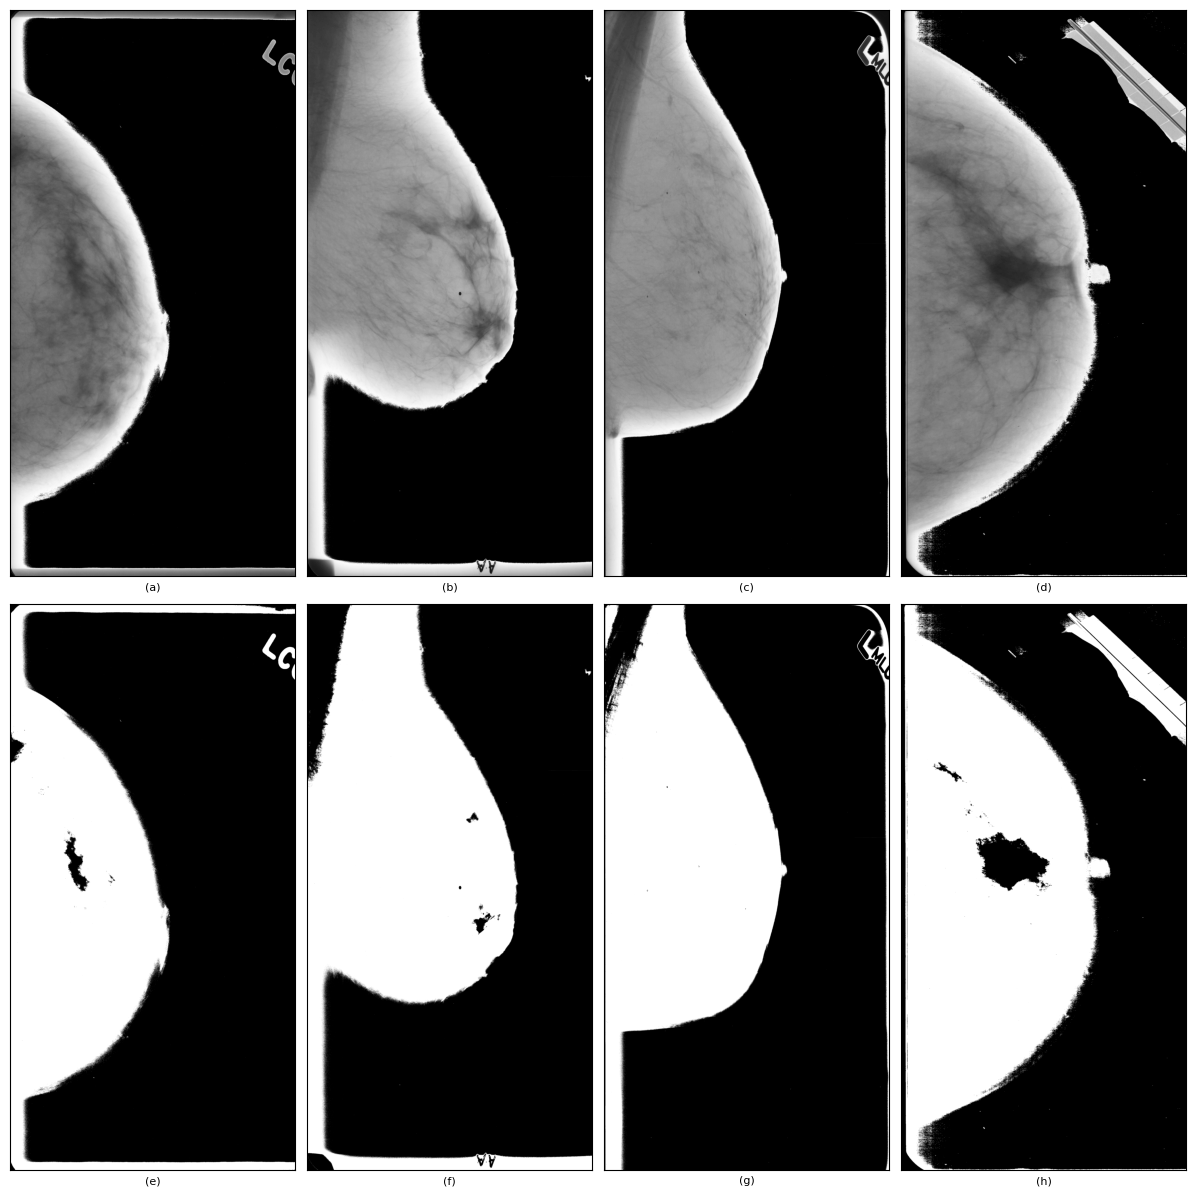

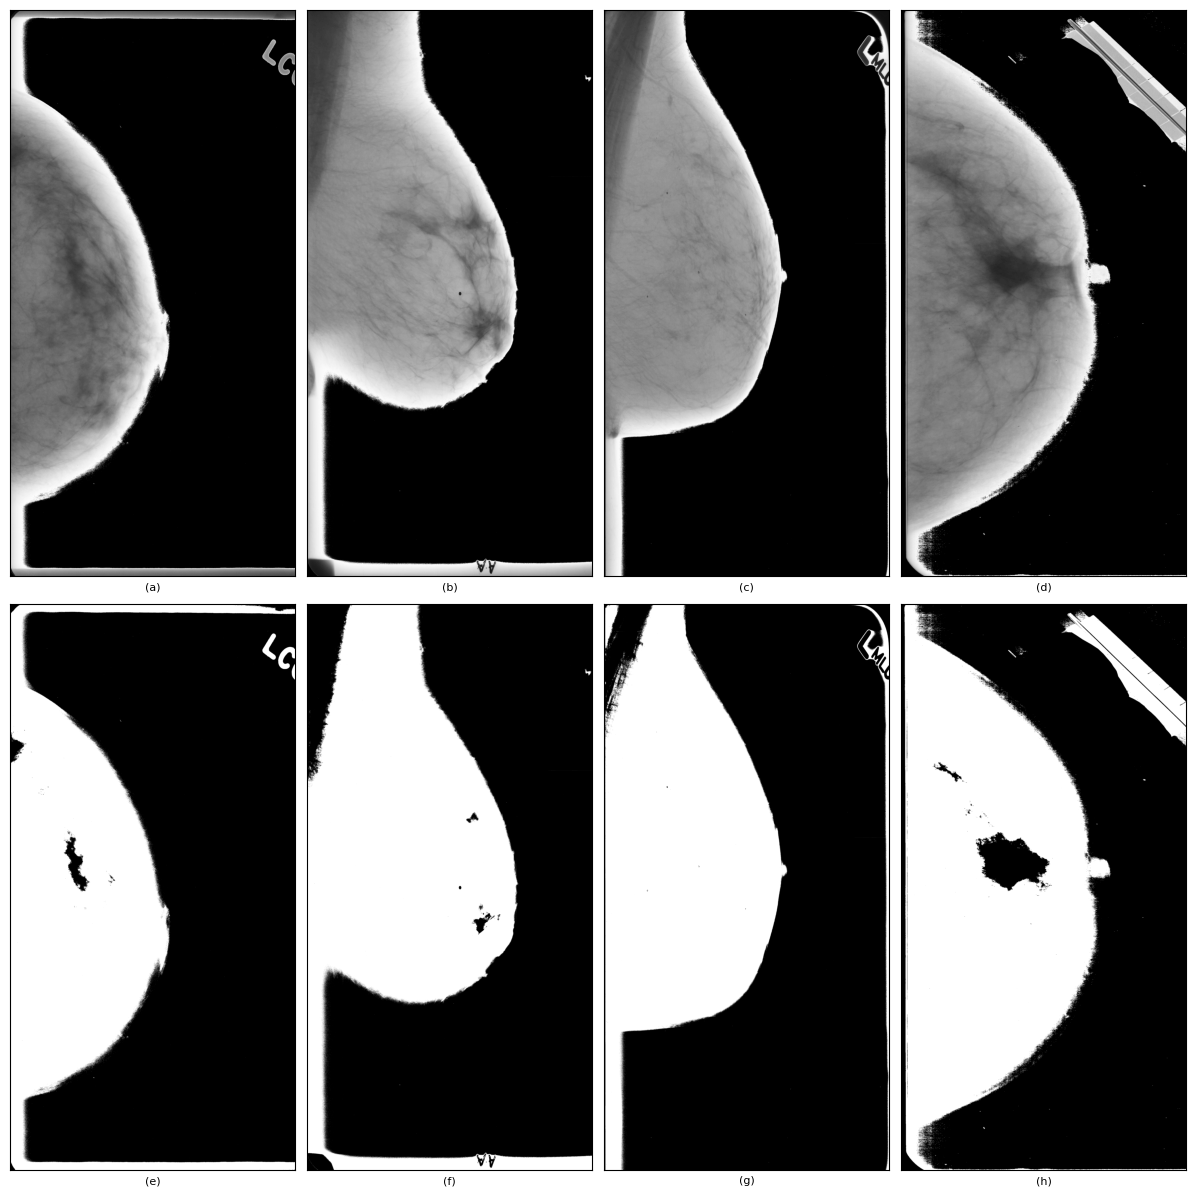

In [3]:
from skimage.filters import threshold_isodata

t1 = threshold_isodata(img1)
t2 = threshold_isodata(img2)
t3 = threshold_isodata(img3)
t4 = threshold_isodata(img4)

bm1 = img1 > t1
bm2 = img2 > t2
bm3 = img3 > t3
bm4 = img4 > t4

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("bm2", fig)

```{glue:figure} bm2
---
align: center
name: bm2_fig
---
Binary Masking with Mean Threshold
```






### Adaptive Thresholding

#### Adaptive Mean Thresholding

Mean thresholding provides an automated method for selecting a global threshold $T$ when the foreground and background regions are sufficiently distinct. For mean thresholding, the following iterative algorithm can serve this purpose:

1. Select an initial value for the global threshold $T$.
2. Segment the image using $T$ in {eq}`global_threshold`  to produce two regions $G_1$ consisting of pixel values > $T$, and $G_2$ consisting of pixel values $\le T$.
3. Compute the mean intensity values $m_1$, and $m_2$ for the pixels in $G_1$ and $G_2$, respectively.
4. Compute a new threshold $T$ midway between $m_1$ and $m_2$.
5. Repeat Steps 2 through 4 until the difference between successive values of $T$ is smaller than a predefined value, $\Delta T$.

Rather than computing these values iteratively, the image histogram can be used to more efficiently compute the global threshold $T$. Hence, the mean threshold method is often referred to as a **histogram shape-based** method. It tends to perform well for pixel values having a bimodal distribution.

Let's examine the binary mask created with Mean thresholding. We'll use the OpenCV 'cv2.adaptiveThreshold' method, which takes five parameters:

1. The input image,
2. The maximum pixel value,
3. The adaptive threshold method, which can be:
   - cv.ADAPTIVE_THRESH_MEAN_C
   - cv.ADAPTIVE_THRESH_GAUSSIAN_C
4. The neighborhood size parameter which specifies the size of the neighborhood around the target pixel from which the mean is calculated, and
5. A constant C which is subtracted from the mean to compute the threshold $T$.

We'll use the ADAPTIVE_MEAN_THRESH_C method with neighborhood size = 11 and $C=2$

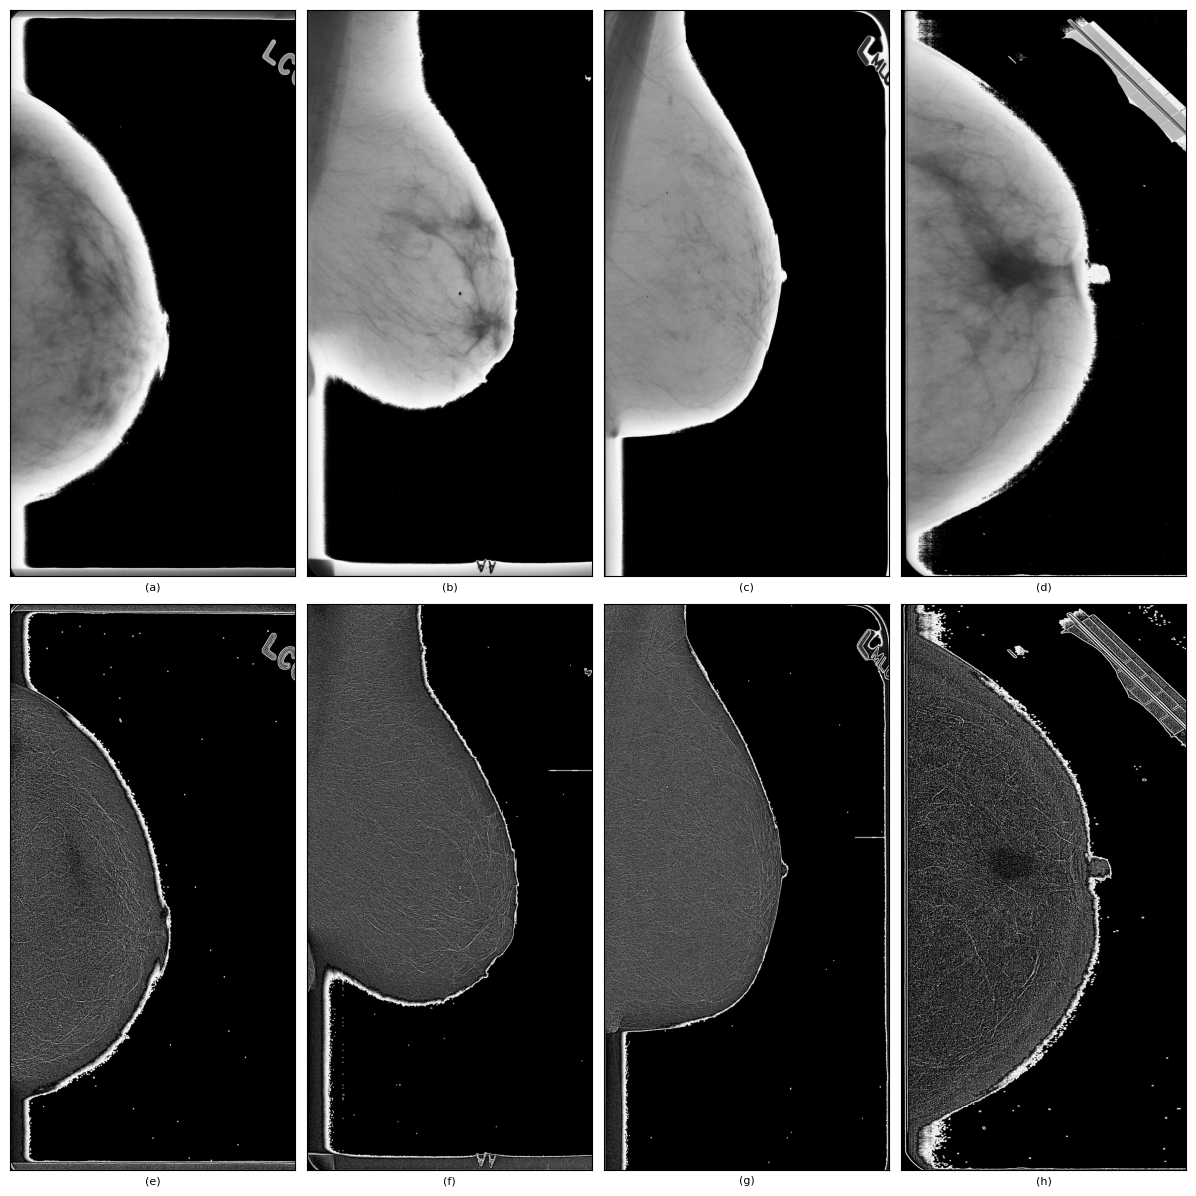

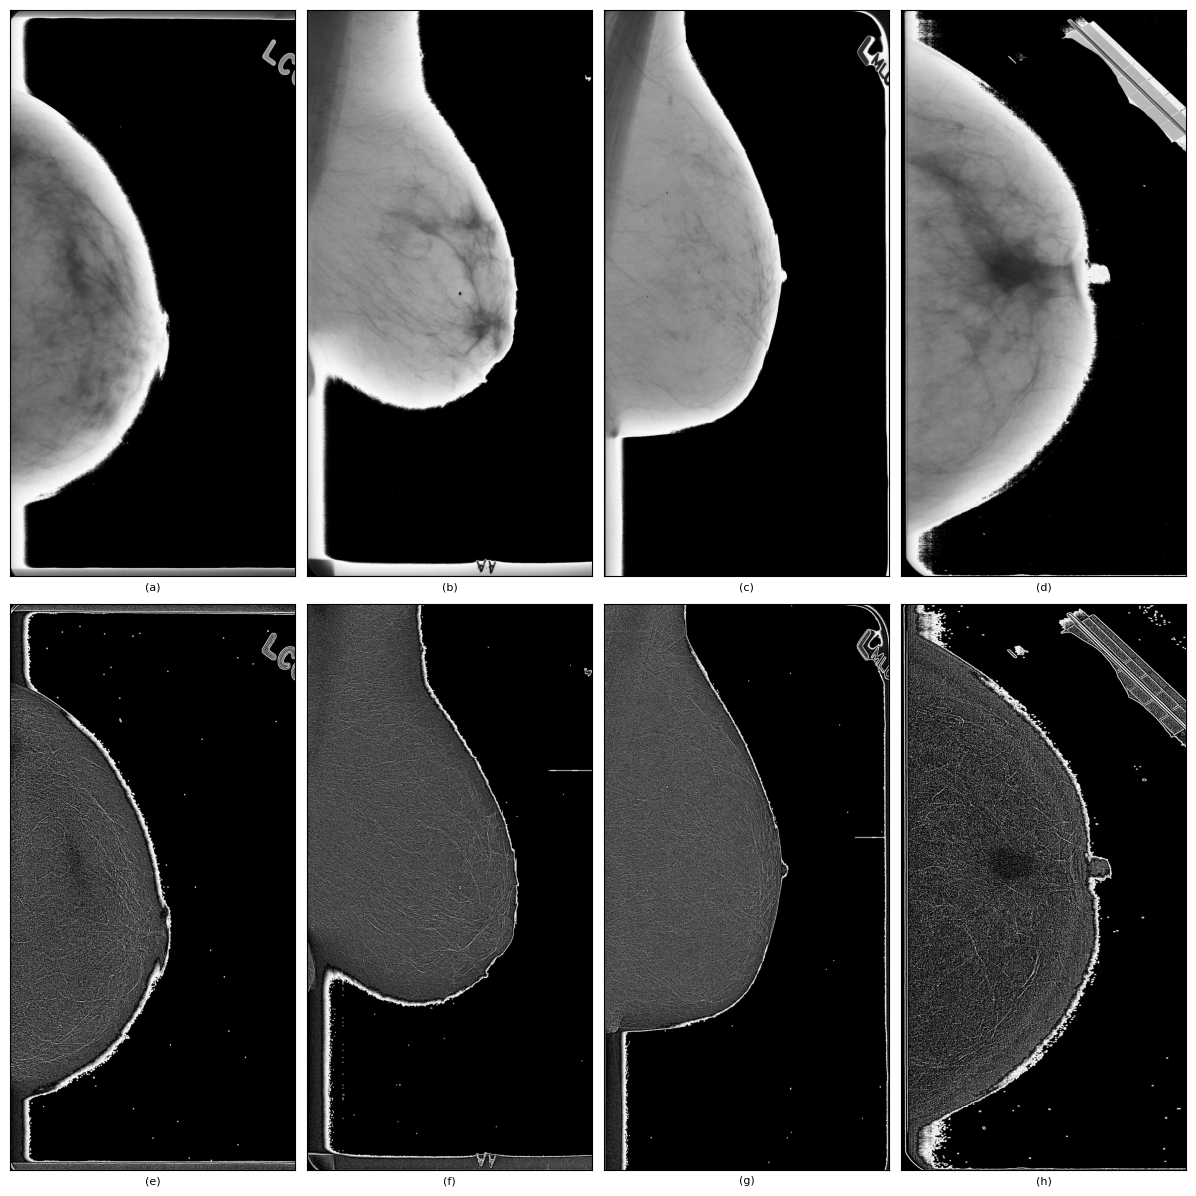

In [4]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import cv2
import numpy as np
import matplotlib.pyplot as plt
from myst_nb import glue
from bcd.utils.image import convert_uint8

bm1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm3 = cv2.adaptiveThreshold(img3, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm4 = cv2.adaptiveThreshold(img4, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("bm3", fig)

```{glue:figure} bm3
---
align: center
name: bm3_fig
---
Binary Masking with Threshold $T=127$
```

In {numref}`bm2_fig` we see.

#### Median Threshold

The Mean threshold method works well for images for which the histogram is bimodal. However, it is not robust to extreme gradients which may affect the mean pixel intensity values. An alternative is to use the *median* in step 3 instead of the mean.